In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df_trafic = pd.read_csv("trafic/comptage-du-trafic-2023-bordeaux-metropole (1).csv", sep=";")
df_acc = pd.read_csv("2023/accidents_bordeaux_cub_2023.csv")


In [4]:
# Assurer que les colonnes sont bien des chaînes
df_acc["adr"] = df_acc["adr"].astype(str)
df_trafic["NOM_VOIE"] = df_trafic["NOM_VOIE"].astype(str)


In [5]:
accidents_par_rue = df_acc.groupby("adr").size().reset_index(name="nb_accidents")


In [6]:
df_merge = pd.merge(
    df_trafic,
    accidents_par_rue,
    left_on="NOM_VOIE",
    right_on="adr",
    how="left"
)

df_merge["nb_accidents"] = df_merge["nb_accidents"].fillna(0).astype(int)


In [7]:
df_merge["MJO_VAL"] = pd.to_numeric(df_merge["MJO_VAL"], errors="coerce")
df_merge["trafic_annuel"] = df_merge["MJO_VAL"] * 365

df_merge["taux_accidents"] = df_merge.apply(
    lambda row: (row["nb_accidents"] / row["trafic_annuel"] * 10000) if row["trafic_annuel"] > 0 else 0,
    axis=1
)


In [8]:
alpha = 1
beta = 1000

df_merge["score_pondere"] = alpha * df_merge["MJO_VAL"] + beta * df_merge["taux_accidents"]


In [9]:
df_merge[["NOM_VOIE", "MJO_VAL", "nb_accidents", "taux_accidents", "score_pondere"]].sort_values(
    by="score_pondere", ascending=False)

,NOM_VOIE,MJO_VAL,nb_accidents,taux_accidents,score_pondere
180,Bordeaux Quai Richelieu Cailhau/Bourse,22165,0,0.0,22165.0
100,Bordeaux Blvd Wilson après Carnot,22012,0,0.0,22012.0
265,Bordeaux Blvd Daney avant Latule,21760,0,0.0,21760.0
151,Bordeaux Pont St Jean,19740,0,0.0,19740.0
41,Bordeaux Quai Grave après Allamandier,18453,0,0.0,18453.0
...,...,...,...,...,...
128,Bordeaux Av. E. Counord après Godard,1006,0,0.0,1006.0
65,Bordeaux Brunet avant Brandenburg,973,0,0.0,973.0
280,Villenave d'Ornon Leclerc avant Gaston,930,0,0.0,930.0
324,Bordeaux Cours de Tournon après la Rue Boudet,823,0,0.0,823.0


In [19]:
#count unique des voies
unique_voies = df_merge["NOM_VOIE"].nunique()
print(f"Nombre de voies uniques : {unique_voies}")


Nombre de voies uniques : 310


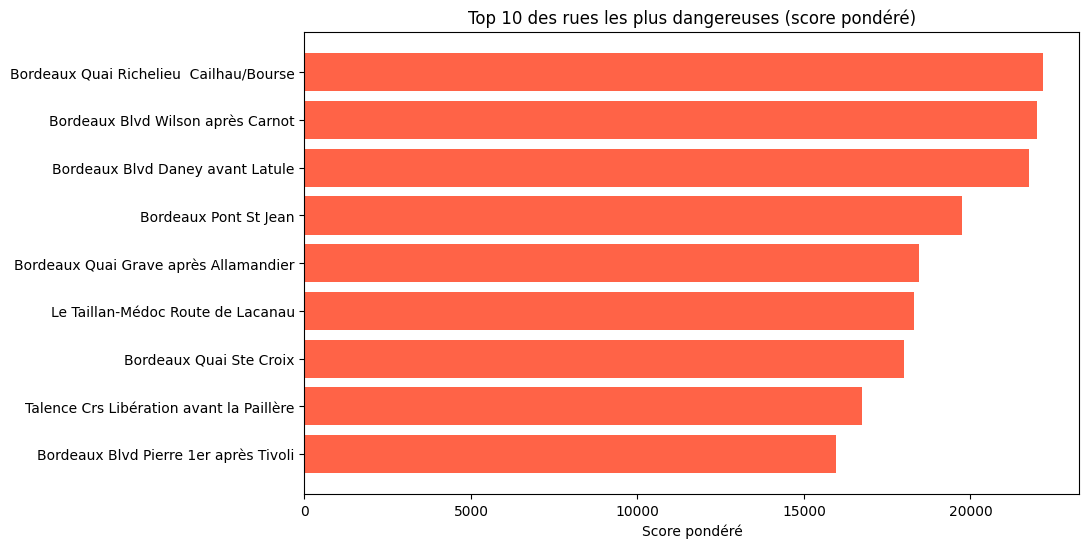

In [10]:
top10 = df_merge.sort_values(by="score_pondere", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10["NOM_VOIE"], top10["score_pondere"], color="tomato")
plt.xlabel("Score pondéré")
plt.title("Top 10 des rues les plus dangereuses (score pondéré)")
plt.gca().invert_yaxis()
plt.show()


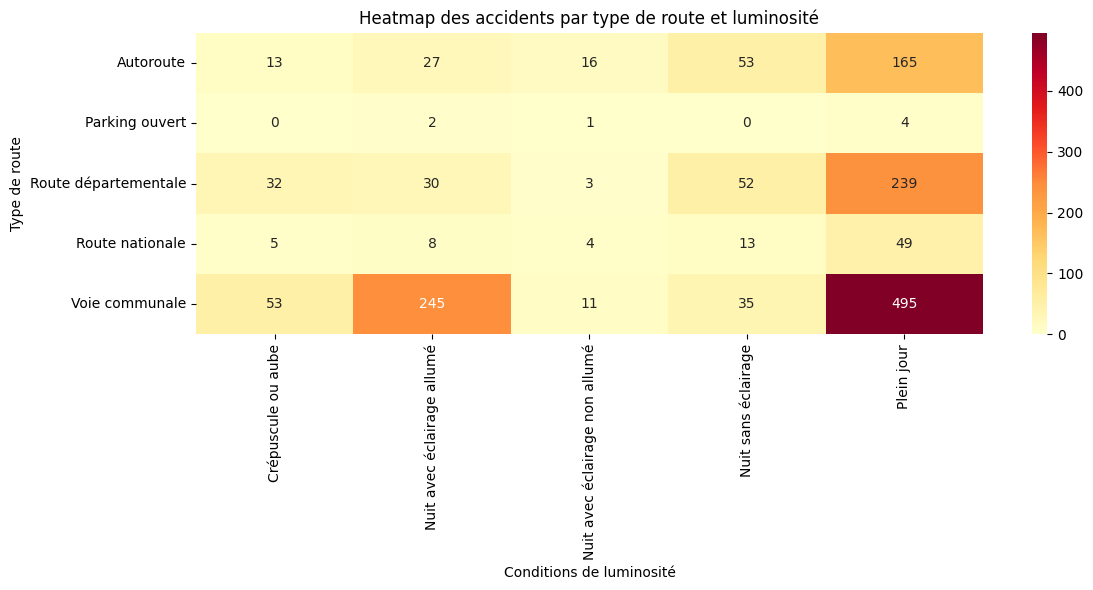

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionnaires de libellés (catr et lum)
catr_labels = {
    "1": "Autoroute",
    "2": "Route nationale",
    "3": "Route départementale",
    "4": "Voie communale",
    "5": "Hors réseau public",
    "6": "Parking ouvert",
    "7": "Métropole urbaine",
    "9": "Autre"
}

lum_labels = {
    1: "Plein jour",
    2: "Crépuscule ou aube",
    3: "Nuit sans éclairage",
    4: "Nuit avec éclairage non allumé",
    5: "Nuit avec éclairage allumé"
}

# Remplace les codes par des libellés
df_acc["catr_str"] = df_acc["catr"].astype(str).map(catr_labels)
df_acc["lum_str"] = df_acc["lum"].astype(int).map(lum_labels)

# Tableau croisé
heatmap_data = pd.crosstab(df_acc["catr_str"], df_acc["lum_str"])

# Affichage de la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlOrRd")
plt.title("Heatmap des accidents par type de route et luminosité")
plt.xlabel("Conditions de luminosité")
plt.ylabel("Type de route")
plt.tight_layout()
plt.show()


# Heatmap des accidents par type de route et luminosité
- Les voies communales en plein jour présentent le plus grand nombre d'accidents (495), suivies de près par :

    - Les routes départementales en plein jour (239)

    - Les voies communales de nuit avec éclairage allumé (245)

- Les autoroutes enregistrent aussi un nombre non négligeable d'accidents en plein jour (165), mais moins que les réseaux urbains (communales et départementales).

- De manière générale, le plein jour est la condition où il y a le plus d’accidents, toutes routes confondues.
Cela est cohérent avec l’intensité du trafic diurne.

---

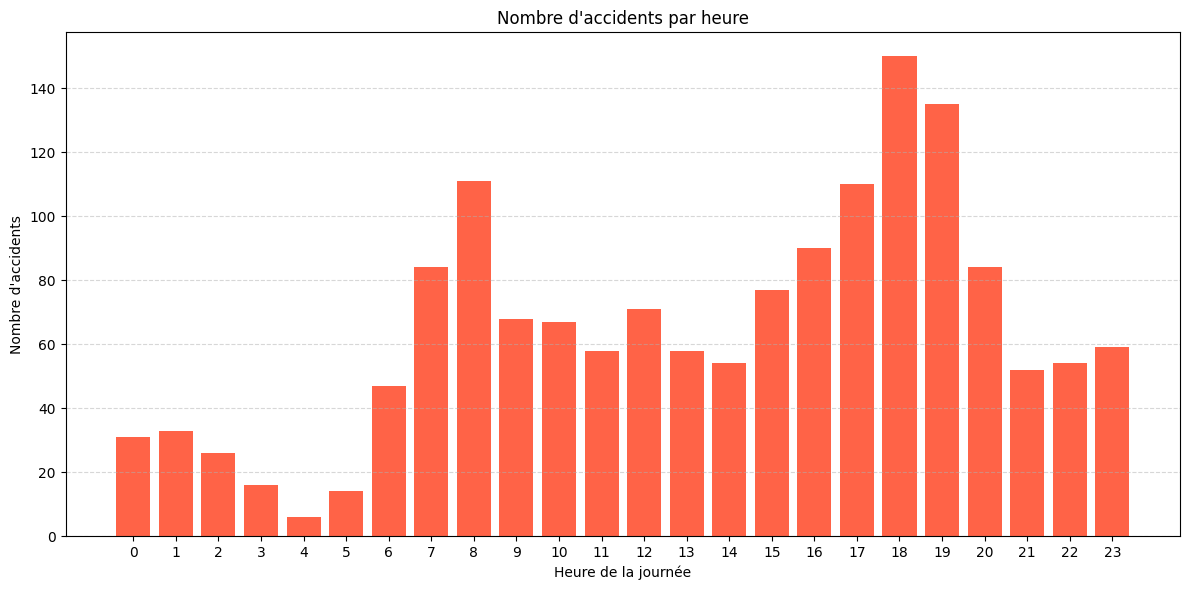

In [30]:
# Extraire l'heure (format 'HH:MM' → HH)
df_acc["heure"] = df_acc["hrmn"].apply(
	lambda x: int(str(x).split(":")[0]) if pd.notnull(x) and ":" in str(x) else None
)

# Compter les accidents par heure
heures_counts = df_acc["heure"].value_counts().sort_index()

# Affichage
plt.figure(figsize=(12, 6))
plt.bar(heures_counts.index, heures_counts.values, color="tomato")
plt.xticks(range(0, 24))
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'accidents")
plt.title("Nombre d'accidents par heure")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Nombre d'accidents par heure

- On remarque un pic clair durant les heures de pointe matinale (7h-9h) et en fin d'après-midi (17h-20h).
- Ces pics correspondent aux périodes de forte circualtion, ce qui confirme que plus il y a de véhicules sur la route, plus le risque d'accident augmente.
- Un léger creux autour de midi et une baisse importante sont aussi visibles, reflétant une baisse du trafic.

---

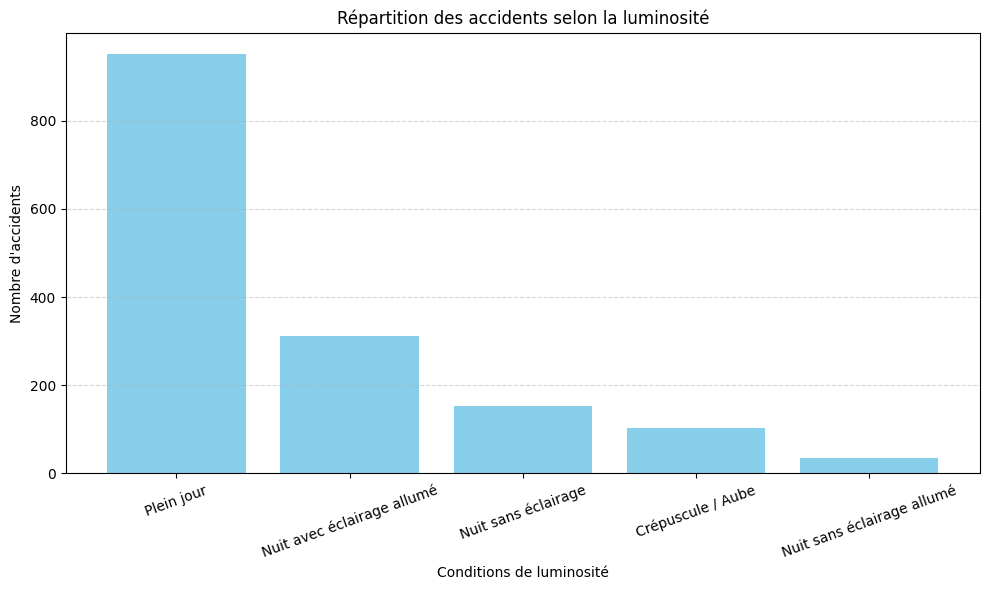

In [41]:
lum_labels = {
    1: "Plein jour",
    2: "Crépuscule / Aube",
    3: "Nuit sans éclairage",
    4: "Nuit sans éclairage allumé",
    5: "Nuit avec éclairage allumé"
}

df_acc["lum_str"] = df_acc["lum"].map(lum_labels)

lum_counts = df_acc["lum_str"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(lum_counts.index, lum_counts.values, color="skyblue")
plt.xlabel("Conditions de luminosité")
plt.ylabel("Nombre d'accidents")
plt.title("Répartition des accidents selon la luminosité")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Répartition des accidents selon la luminosité

- La majorité des accidents surviennent en plein jour, ce qui est normal car c'est la période où le trafic est le plus dense.
- Toutefois, on observe un nombre non négligeable d'accidents la nuit, notamment dans des zones éclairées.
- Cela indique que la nuit, malgré un trafic réduit, la visibilité plus faible contribue toujours au risque.

---

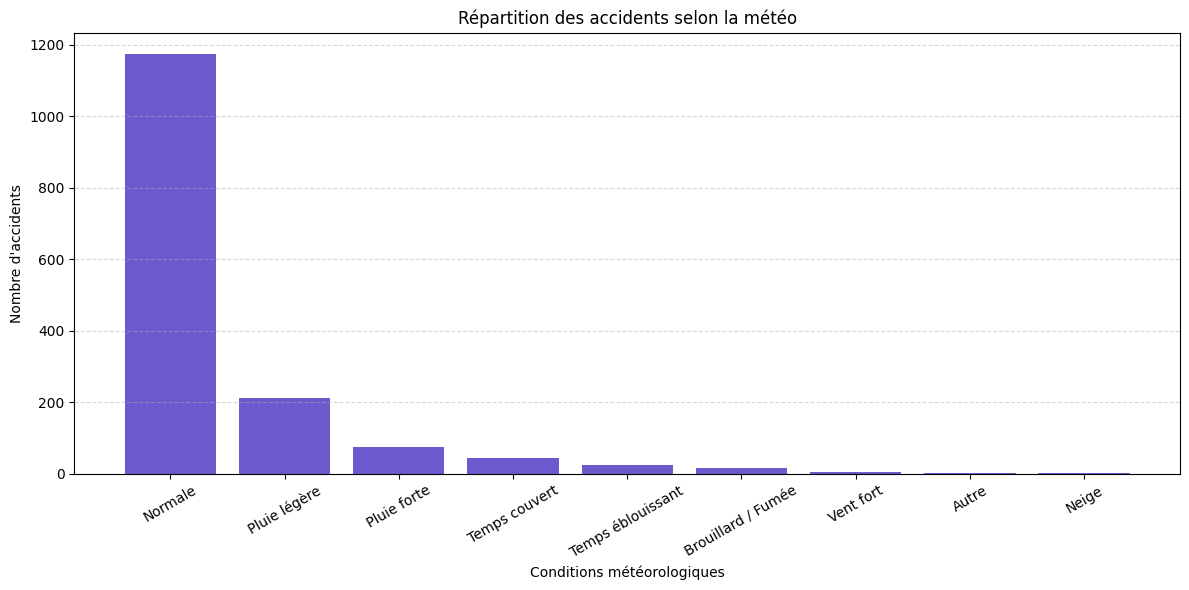

In [45]:
atm_labels = {
    1: "Normale",
    2: "Pluie légère",
    3: "Pluie forte",
    4: "Neige",
    5: "Brouillard / Fumée",
    6: "Vent fort",
    7: "Temps éblouissant",
    8: "Temps couvert",
    9: "Autre",
    -1: "Non renseigné"
}

df_acc["atm_str"] = df_acc["atm"].map(atm_labels)

atm_counts = df_acc["atm_str"].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(atm_counts.index, atm_counts.values, color="slateblue")
plt.xlabel("Conditions météorologiques")
plt.ylabel("Nombre d'accidents")
plt.title("Répartition des accidents selon la météo")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Répartition des accidents selon la météo

- Une majorité des accidents ont lieu par temps normal ou clair, cohérent avec la fréquence des conditions météo.

- Une proportion significative des ces accidents survient sous la pluie. La météo est un facteur aggravant, mais non suffisant seul pour provoquer un accident.

- La neige est très peu représenter en raison de la région


----

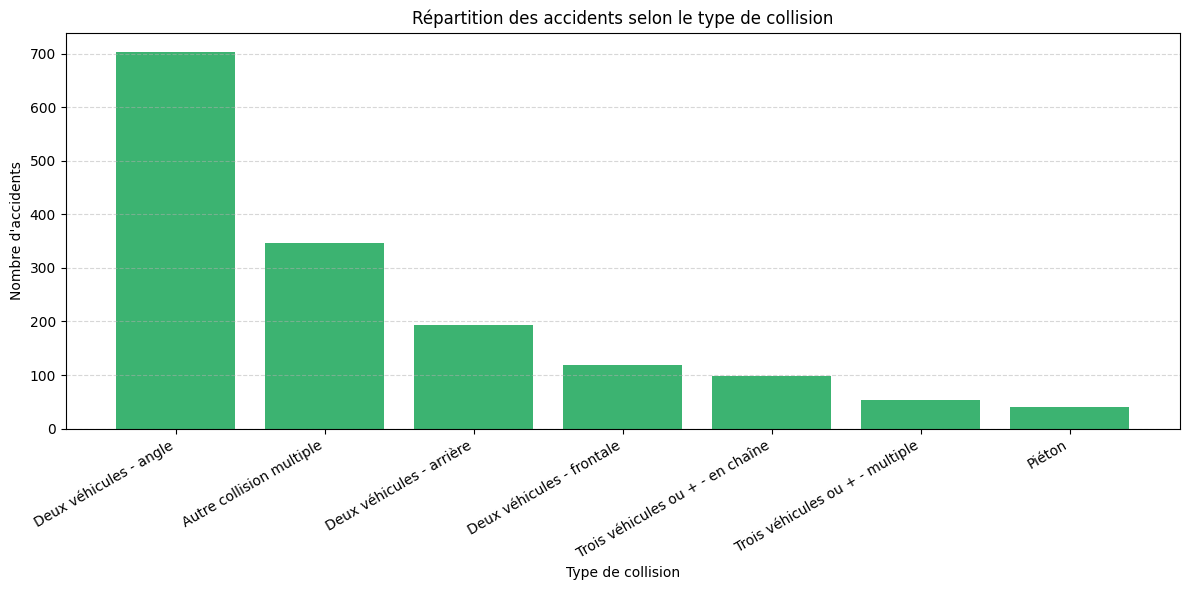

In [ ]:
col_labels = {
    1: "Deux véhicules - frontale",
    2: "Deux véhicules - arrière",
    3: "Deux véhicules - angle",
    4: "Trois véhicules ou + - en chaîne",
    5: "Trois véhicules ou + - multiple",
    6: "Autre collision multiple",
    7: "Piéton",
    8: "Véhicule seul",
    9: "Autre"
}

df_acc["col_str"] = df_acc["col"].map(col_labels)

col_counts = df_acc["col_str"].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(col_counts.index, col_counts.values, color="mediumseagreen")
plt.xlabel("Type de collision")
plt.ylabel("Nombre d'accidents")
plt.title("Répartition des accidents selon le type de collision")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



# Répartition des accidents selon le type des collision

- Le type de collision le plus fréquent est l’angle entre deux véhicules, avec plus de 700 cas recensés.

    👉 Cela reflète une vulnérabilité particulière aux intersections, souvent mal anticipées ou mal priorisées.
- Viennent ensuite les collisions multiples et les chocs arrière, qui peuvent être causés par :

    - Des embouteillages

    - Une mauvaise gestion des distances de sécurité

    - Un manque d’attention ou de visibilité

- Les collisions frontales sont moins nombreuses, mais souvent plus graves en termes de conséquences corporelles.

- Les accidents impliquant des piétons restent faibles en nombre, mais doivent être pris très au sérieux, car leur gravité est souvent élevée. Ces cas nécessitent une sécurisation renforcée des passages piétons et zones de traversée urbaine.
